# 1. Wczytanie danych z IMDb (ograniczenie do 300 losowych filmów)

In [4]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from dotenv import load_dotenv
load_dotenv()


with open("api_key.txt", "r") as file:
    API_KEY = file.read().strip()



imdb_df = pd.read_csv("imdb_data.csv")
imdb_df = imdb_df.sample(n=300, random_state=42).reset_index(drop=True)

print(imdb_df.head())
print(imdb_df.info())
print(imdb_df.describe())


          id      primaryTitle     originalTitle  isAdult  runtimeMinutes  \
0  tt0816692      Interstellar      Interstellar        0             169   
1  tt1840309         Divergent         Divergent        0             139   
2  tt0424345         Clerks II         Clerks II        0              97   
3  tt0325710  The Last Samurai  The Last Samurai        0             154   
4  tt3416532   A Monster Calls   A Monster Calls        0             108   

                     genres  averageRating  numVotes     budget        gross  \
0    Adventure,Drama,Sci-Fi            8.7   2009279  165000000  703170837.0   
1  Action,Adventure,Mystery            6.6    479336   85000000  288885818.0   
2                    Comedy            7.3    139558    5000000   26986174.0   
3              Action,Drama            7.8    461081  140000000  454627263.0   
4    Adventure,Drama,Family            7.4     92032   43000000   47309313.0   

        release_date          directors  
0   October 26

# 2. Funkcja do pobierania popularności z TMDb API

In [5]:
def fetch_tmdb_popularity(titles, api_key, cache_file="tmdb_trends.parquet"):
    if os.path.exists(cache_file):
        return pd.read_parquet(cache_file)

    base_url = "https://api.themoviedb.org/3/search/movie"
    results = []

    for title in titles:
        params = {
            "api_key": api_key,
            "query": title
        }
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            if data["results"]:
                result = data["results"][0]
                results.append({
                    "title": title,
                    "trend_score": result.get("popularity", 0)
                })
            else:
                results.append({"title": title, "trend_score": 0})
        except Exception as e:
            print(f"Error for '{title}': {e}")
            results.append({"title": title, "trend_score": 0})
        time.sleep(0.2)

    df = pd.DataFrame(results)
    df.to_parquet(cache_file)
    return df

#3. Pobieranie danych TMDb (dla 300 tytułów)

In [6]:
titles_300 = imdb_df['primaryTitle'].unique()
tmdb_df = fetch_tmdb_popularity(titles_300, api_key=API_KEY)

# Łączenie danych
df = pd.merge(imdb_df, tmdb_df, left_on='primaryTitle', right_on='title', how='left')


#4. Czyszczenie danych

In [7]:
df['trend_score'] = df['trend_score'].fillna(0)
df = df.dropna(subset=['gross'])

# Usunięcie outlierów na podstawie numVotes
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(df[['numVotes']])
df = df[mask == 1]

#5. Przygotowanie cech (genres rozbijamy na binarne kolumny)

In [8]:
df['genres'] = df['genres'].fillna('')
df_genres = df['genres'].str.get_dummies(sep=',')

target = 'gross'

features = ['runtimeMinutes', 'averageRating', 'trend_score', 'isAdult', 'budget'] + list(df_genres.columns)

X = pd.concat([df[features[:5]], df_genres], axis=1)
y = np.log1p(df[target])

# Skalowanie cech numerycznych i binarnych
numeric_features = features

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
])

#6. Podział na dane treningowe i testowe

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#7. Model regresji RandomForest

In [10]:
regressor = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

regressor.fit(X_train, y_train)
y_pred_log = regressor.predict(X_test)
y_pred = np.expm1(y_pred_log)  # odwrócenie logarytmu


#8. Ocena modelu

In [11]:
def evaluate_regression_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print("Ocena modelu regresji:")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")

#9. Wykres ważności cech

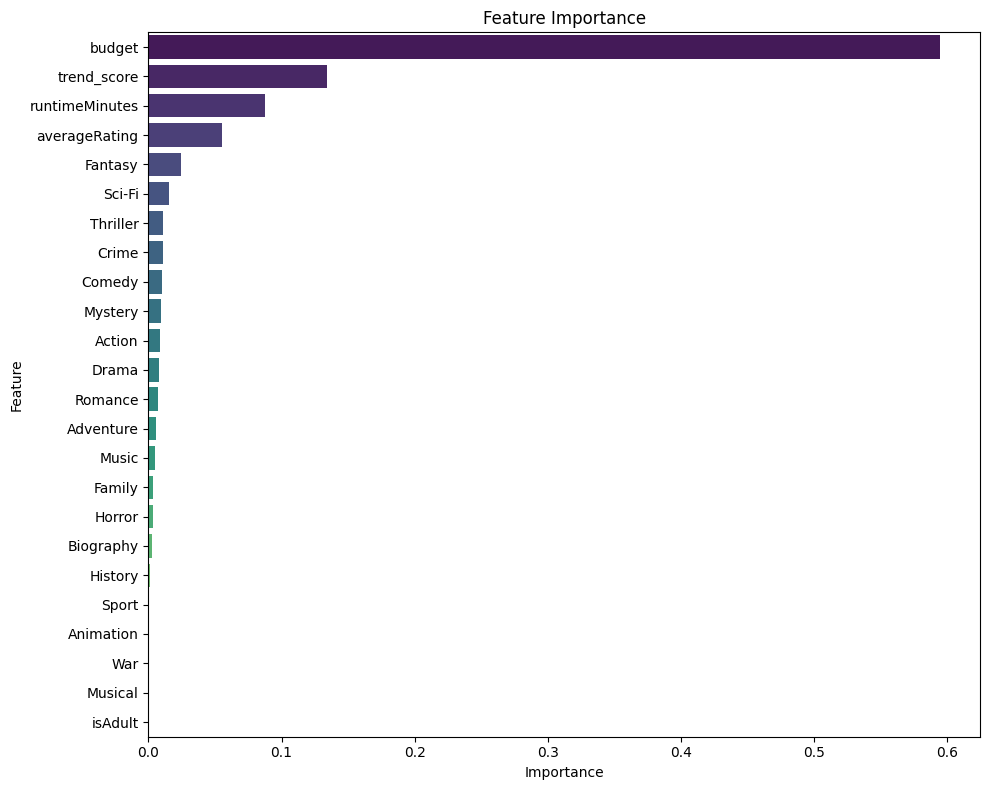

Ocena modelu regresji:
MAE:  75173103.6329
MSE:  15819373241031114.0000
RMSE: 125775089.9067
R2:   0.4070


In [12]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_df = feature_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_df, x='Importance', y='Feature',
                hue='Feature', dodge=False, palette='viridis', legend=False)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.legend([],[], frameon=False)  # ukrycie legendy
    plt.show()


plot_feature_importance(regressor.named_steps['regressor'], numeric_features)
evaluate_regression_model(np.expm1(y_test), y_pred)